# Basic Analysis of Survey Data - Mental Health & Happiness

## 1. Import data

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import csv file to pandas df
csv_file_path = '2020_survey_data.csv'
df = pd.read_csv(csv_file_path)

In [3]:
df.head()

,PID,HNO,AREA,EDM,ANS_TYPE,ANS_SUB1,ANS_SUB2,ANS_SUB3,S9_0,S9_2,...,RES_YY,RES_MM,RES_AGE,RES_MAR,RES_EDU1,RES_EDU2,RES_YN,RES_SUB,f_wgt1,s_wgt1
0,7501,1,35,2,0,99,999,1,0,99,...,1952,10,67,1,4,9,1,9,393.325736,0.512734
1,7601,1,35,2,0,99,999,1,0,99,...,1951,12,68,3,2,0,1,9,393.325736,0.512734
2,7802,2,23,1,0,99,999,1,1,1,...,1954,3,66,2,5,12,1,9,587.163656,0.765418
3,7801,1,23,1,0,99,999,1,0,99,...,1954,1,66,2,5,12,1,9,640.643430,0.835133
4,8001,1,35,1,0,99,999,1,0,99,...,1951,12,68,3,3,6,1,9,493.769927,0.643671


In [4]:
df.shape

(10097, 915)

## 2. Data Preprocessing

### 2-1. B6의 삶의 만족도(우울증 조사) 부분 설문조사 총점 합산하기

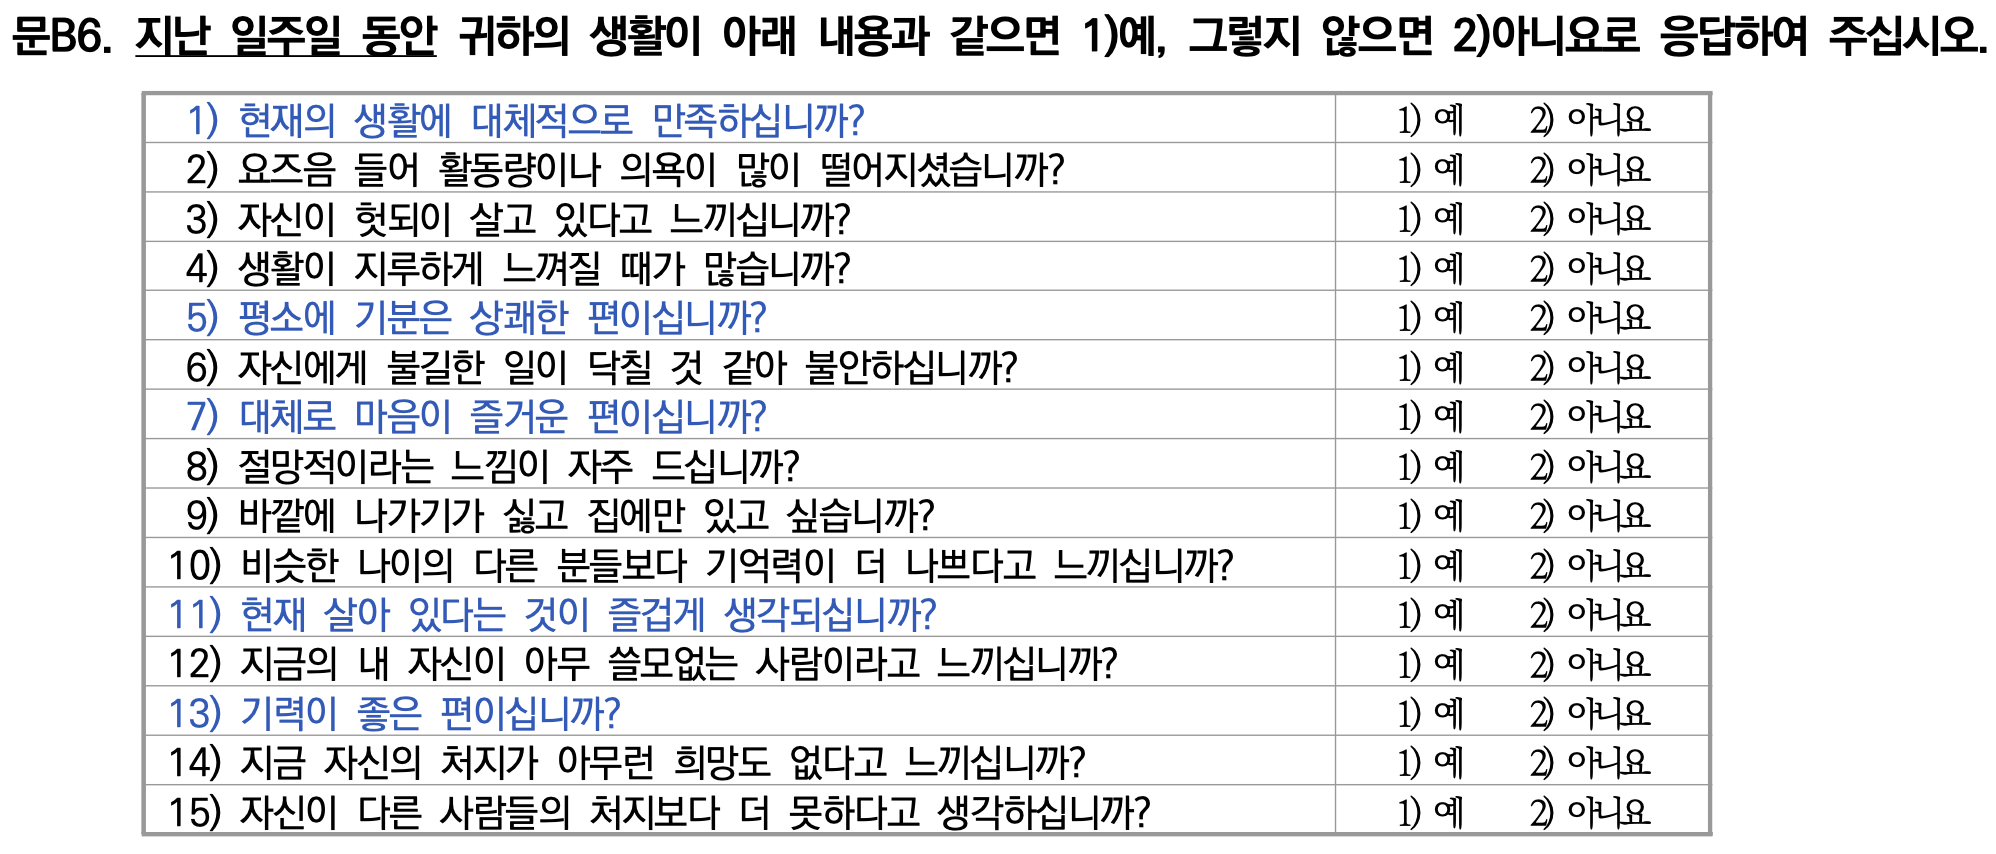

In [24]:
from IPython.display import Image
Image(filename='images/depression_survey.png')

- 1,5,7,11문항은 1->1점, 2->0점
- 2,3,4,6,8,9,12,14,15문항은 1->0점, 2->1점
- 10,13 제외 (심리상태보다 객관적 신체조건에 대한 질문인 것 같아 제외함)

In [5]:
# Filter columns of interest except B6_10, B6_13
cols = df.filter(regex='^B6_[^1013]$').columns

# Check if any of the columns in each row contains a 9
contains_9 = df[cols].isin([9]).any(axis=1)

# Drop rows where at least one column contains a 9
df = df.loc[~contains_9]

In [6]:
df.shape

(9920, 915)

In [7]:
# For "B6_X", where X is one of 2,3,4,6,8,9,12,14,15, if the value is 1, change it to 0. If it is 2, change it to 1.
cols_1 = ["B6_2", "B6_3", "B6_4", "B6_6", "B6_8", "B6_9", "B6_12", "B6_14", "B6_15"]
df[cols_1] = df[cols_1].replace({1 : 0, 2 : 1})

# For "B6_X", where X is one of 1,5,7,11, if the value is 1, leave it as 1. If it is 2, change it to 0.
cols_2 = ["B6_1", "B6_5", "B6_7", "B6_11"]
df[cols_2] = df[cols_2].replace({2: 0})

# Add a column named "mental_health_score", which is the sum of all these columns except B6_10 and B6_13
cols_to_sum = cols_1 + cols_2
df['mental_health_score'] = df[cols_to_sum].sum(axis=1)


#### 정신건강 점수 분포

In [8]:
df['mental_health_score'].describe()

count    9920.000000
mean       10.236895
std         2.991794
min         0.000000
25%         9.000000
50%        11.000000
75%        13.000000
max        13.000000
Name: mental_health_score, dtype: float64

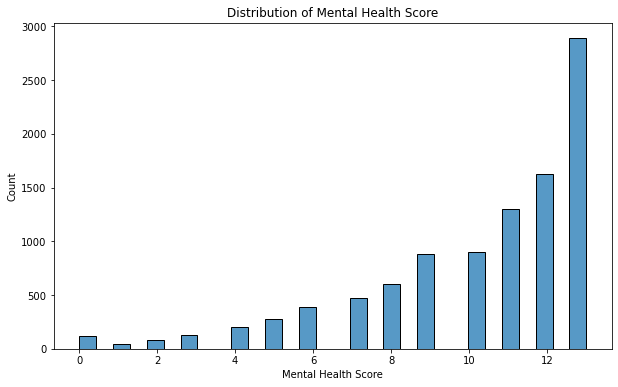

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df['mental_health_score'],bins=30)
plt.title('Distribution of Mental Health Score')
plt.xlabel('Mental Health Score')
plt.show()

중요 covariates:
- B2_3: 의사진단 만성질환 총 수
- S5_1: 가구원 수
- B9_1a: 운동 빈도(일)_(일주일 기준)(9는 결측처리)
- B9_2a: 운동 시간(분)_(1회 기준) (999는 결측처리)
- E1_6: 월소득
- total equity: 부동산 + 금융자산 + 기타자산 - 부채


df['total_equity'] = df['J6b_1'] + df['J6b_2'] + df['J6b_3'] - df['J6b_4']

### 2-2 데이터 사칙연산(?!)

In [12]:
# 1. 가구 총 수입액, 월평균 소비지출액, 월평균 주거비 지출액, 월소득 결측치 제거
df = df[df["J3b_3_13"] != 999998]
df = df[df["J3b_3_13"] != 999999]
df = df[df["J4"] != 999998]
df = df[df["J4"] != 999999]
df = df[df["J4_1"] != 999998]
df = df[df["J4_1"] != 999999]
df = df[df["E1_6"] != 99998]
df = df[df["E1_6"] != 99999]
# 2. 부동산 자산 금액, 금융자산 금액, 기타자산 금액, 부채 금액 결측치 제거
df = df[df["J6b_1"] != 999998]
df = df[df["J6b_1"] != 999999]
df = df[df["J6b_2"] != 999998]
df = df[df["J6b_2"] != 999999]
df = df[df["J6b_3"] != 999998]
df = df[df["J6b_3"] != 999999]
df = df[df["J6b_4"] != 999998]
df = df[df["J6b_4"] != 999999]

In [14]:
# 부동산 자산  + 금융자산 + 기타자산 - 부채 금액
df['total_equity'] = df['J6b_1'] + df['J6b_2'] + df['J6b_3'] - df['J6b_4']
# 가구 월평균 주거비/ 월평균 총소비
df['rent_portion'] = df['J4_1']/df['J4']
# 월평균 총소비 - 월평균 주거비
df['monthly_spending_no_rent'] = df['J4'] - df['J4_1']
#(월평균 총소비 - 월평균 주거비) / 가구수
df['monthly_spending_no_rent_per_capita'] = df['monthly_spending_no_rent']/df['S5_1']

## 3. Data Visualization

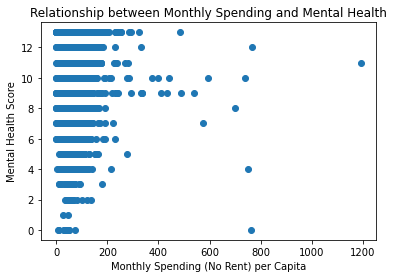

In [16]:
x = df["monthly_spending_no_rent_per_capita"]
y = df["mental_health_score"]

# Plot the graph
plt.scatter(x, y)
plt.xlabel("Monthly Spending (No Rent) per Capita")
plt.ylabel("Mental Health Score")
plt.title("Relationship between Monthly Spending and Mental Health")
plt.show()

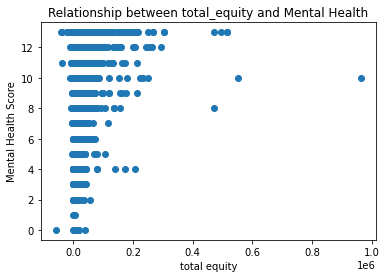

In [25]:
x = df["total_equity"]
y = df["mental_health_score"]

# Plot the graph
plt.scatter(x, y)
plt.xlabel("total equity")
plt.ylabel("Mental Health Score")
plt.title("Relationship between total_equity and Mental Health")
plt.show()

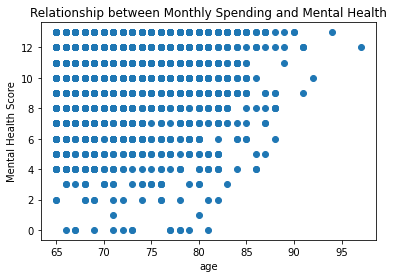

In [20]:
x = df["RES_AGE"]
y = df["mental_health_score"]

# Plot the graph
plt.scatter(x, y)
plt.xlabel("age")
plt.ylabel("Mental Health Score")
plt.title("Relationship between age and Mental Health")
plt.show()

여기까지 보았을 때, 과연 우울증 검사 결과가 소득수준, 재산 수준, 나이 등과 아주 큰 상관관계가 있는지는 의문입니다.